# Vision Transformers in PyTorch

In this notebook, we will explore Vision Transformers (ViTs), a powerful deep learning architecture for image classification. ViTs leverage the self-attention mechanism from natural language processing to process image patches as sequences. Your task is to implement the encoder portion of the ViT model, which is responsible for processing the input images and extracting features from the image patches. You will implement the `Attention`, `PatchEmbed`, and part of the `VisionTransformer` classes, focusing on the `prepare_tokens` method to tokenize the input image into patches and incorporate positional encodings. The attention head and block architecture classes have been completed for you.

Please read the entire notebook before starting. You may find it useful to refer to the lecture notes on sequence modelling for this task. For further background reading, you may be interested in the [original paper](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) on transformers and its [adaption to computer vision](https://arxiv.org/pdf/2010.11929).

In [ ]:
# basic imports
import os
import torch
import torch.nn as nn
from tqdm import tqdm

import time
import matplotlib.pyplot as plt
import torch.nn.functional as F

## The encoder block

Implement the attention head of the transformer in the below class. Note there is an option to initialise multiple attention heads. Instead of creating a separate module for each attention head and combining them, we will create a single `nn.Linear` layer to apply the weight matrices for query, key, value, with an extra dimension to accommodate all heads.

To do this, initialise the `self.qkv` linear layer. Remember the input size is the number of features (dimensionality) of the model, $d_{\textrm{model}}$. The output will be three times as large, giving us distinct weights for each of the $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ (query, key, value) matrices.
1. Apply this linear layer to the input, then `reshape` its last dimension so that we have dimensions each for the $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ matrices, individual attention heads, and the features for each head. The result should be of shape `(B, N, 3, num_heads, C // num_heads)`.
2. Retrieve the $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ matrices. It may be helpful to permute the `qkv` tensor to shape `(3, B, num_heads, N, C // num_heads)`.
3. Compute the scaled dot-product self-attention. As a reminder, this is given by
$$ \mathbf{Y} = \mathrm{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \mathbf{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^{\top}}{\sqrt{(D_k)}}\right) \mathbf{V},$$
where $D_k$ is the dimension of the *keys*. In multi-headed attention, this is the dimensionality of the model divided by the number of heads.
4. Ensure the output dimensions match the input dimensions using `reshape`.

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5 # scale factor to prevent vanishing gradients

        # create linear layer, combined matrix of weights for Q, K, V
        self.qkv =

    def forward(self, x):
        B, N, C = x.shape # (batch size, n_patches+1, d_model)
        qkv = ...
        q, k, v = ...
        # compute scaled inner product QK^T

        # apply softmax layer; we will save the result
        attn = ...
        # compute inner product with V

        # reshape to match input dimensions

        return x, attn

We have already defined the MLP (Multilayer Perceptron; fully connected feed-forward) layer, which consists of two linear transformations with a GELU (Gaussian Error Linear Unit) activation in between.

In [ ]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

 We'll complete the encoder block of the transformer by combining the attention head and the MLP sub-layers. Complete the `forward()` method below by adding [layer normalisation](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) (*pre-norm*) to each sub-layer, followed by residual connections that bypass the multi-head structure. You may find slide 29 of your sequence modelling lecture notes helpful.

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, act_layer=nn.GELU):
        super().__init__()
        self.norm1 = ...
        self.attn = Attention(dim, num_heads=num_heads)
        self.norm2 = ...
        self.mlp = Mlp(in_features=dim, hidden_features=dim, act_layer=act_layer)

    def forward(self, x, return_attention=False):
        # pre-norm and apply attention sub-layer

        if return_attention: # for attention visualization - do not change
            return
        # add residual connection

        # pre-norm and apply MLP sub-layer

        # add residual connection

        return x

We now need to embed the input images before they are fed into the encoder. For this, we need a class that will slice an image into patches, then 'flatten' those patches (as one-dimensional tensors) and project them into a linear embedding. We can do this in one step using the `Conv2d` method.

Set the `kernel_size` to patch size - this breaks the image up into square patches of the desired shape - and also set the `stride` to patch size, which ensures that there is no overlap between the patches as they are flattened.

Finally, set the second argument, `out_channels`, to the size of the embedding dimension: `embed_dim`, the dimensionality of the model. You will pass this value as an argument later when initialising the model.

In [ ]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        num_patches = ... # can infer from image size and patch size. Remember to use // to ensure int type.
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        # create embedding using Conv2d
        self.proj = ...

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2) # apply projection, flatten, and reshape to (batch size, n_patches, d_model)
        return x

Finally, we can construct the model architecture, using each of the classes defined above. The forward pass is already defined, so we will complete the positional encoding. Initialise the class variable `self.patch_embed` as an instance of the `PatchEmbed()` class completed above. Then, fill in the tokenisation method `prepare_tokens()` using this instance to create a linear embedding of the data. Finally, complete the encoder with two more learnable parameters: concatenate `[class]` tokens to the linear embedding, then add positional positional encodings to each token.

Some hints:
- Remember that the input is a *batch* of patch embeddings comprising multiple images. In order to create class tokens for every image in the batch, it is helpful to use the [`.expand()` class function](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) to match the first dimension to that of the input. You can then concatenate the class tokens and linear embedding.
- Add the positional encoding to each patch+position embedding with a residual connection.
- You may find it useful to refer to slides 30 and 36 from the lecture on sequence modelling.

In [ ]:
class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size, patch_size, num_classes, embed_dim, depth, num_heads, in_chans=3):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        self.blocks = nn.ModuleList([ Block( dim=embed_dim, num_heads=num_heads) for i in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def prepare_tokens(self, x):
        x = self.patch_embed(x)  # patch linear embedding, shape (batch size, n_patches, d_model)

        # expand the [CLS] token and concat to linear embedding
        cls_tokens = ...
        x = ...

        # add positional encoding to each token
        x = ...

        # output should be shape (batch size, n_patches+1, d_model)
        return x

    def forward(self, x):
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return self.head(x[:, 0])

    def get_last_selfattention(self, x):
        # for visualisation purposes
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                return blk(x, return_attention=True)

## Model Set-up

We have provided some utility functions below to download a dataset, train the model, and evaluate and visualise the results.

For this experiment we will use the CIFAR-10 dataset, a collection of small images commonly used for image classification tasks in machine learning. There are 10 object classes (airplane, frog, ship...) with 5,000 training and 1,000 testing images per class. You can see some examples of the training images below.

In [ ]:
def class_accuracy(predictions, labels):
    y = torch.max(predictions, 1)[1]
    y_labels = torch.max(labels, 1)[1]

    return torch.mean(y.eq(y_labels).float())

In [ ]:
def read_cifar():
    import torchvision.datasets as datasets
    import torchvision.transforms as transforms

    # code from https://github.com/jeonsworld/MLP-Mixer-Pytorch/blob/main/utils/data_utils.py
    transform_train = transforms.Compose( [ transforms.ToTensor(), ])
    transform_test = transforms.Compose( [ transforms.ToTensor(), ])

    train_data = datasets.CIFAR10(
        root="data", train=True, download=True, transform=transform_train, target_transform=transforms.Lambda(
            lambda y: torch.zeros(10).scatter_(0, torch.tensor(y), value=1)
        )
    )
    test_data = datasets.CIFAR10(
        root="data", train=False, download=True, transform=transform_test, target_transform=transforms.Lambda(
            lambda y: torch.zeros(10).scatter_(0, torch.tensor(y), value=1)
        )
    )

    class DataSets(object):
        pass

    data_sets = DataSets()

    data_sets.train = train_data
    data_sets.test = test_data

    return data_sets

In [ ]:
model = VisionTransformer(img_size=32, patch_size=8, embed_dim=192, depth=3, num_heads=3, num_classes=10)

if torch.cuda.is_available(): # i.e. for NVIDIA GPUs
    device_type = "cuda"
else:
    device_type = "cpu"

device = torch.device(device_type) # Select best available device
model = model.to(device)

print(f'Running on device: {device}')


lr = 0.0005
weight_decay = 1e-5

opt = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)

st = time.time()
eval_time = 0

n_steps = 0
n_test_steps = 0

Running on device: cuda


100%|██████████| 170498071/170498071 [00:03<00:00, 49258036.86it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Number of training samples:  50000
Number of testing samples:  10000
Image shape:  torch.Size([3, 32, 32])


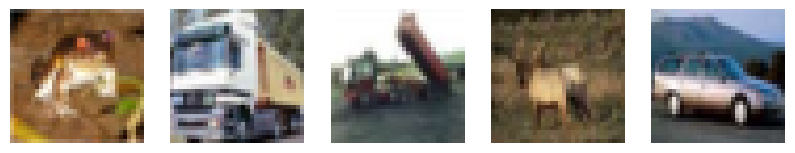

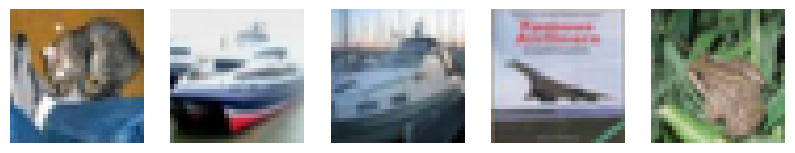

In [ ]:
def plot_images(dataset, n_images):
    img_list = []
    fig, axs = plt.subplots(1, n_images, figsize=(n_images * 2, 2))
    if n_images == 1:
        axs = [axs]
    for i, ax in enumerate(axs):
        img = dataset[i][0]
        img_list.append(img)
        label = dataset[i][1]
        if img.shape[0] == 3:
            img = img.permute(1, 2, 0)

        ax.imshow(img)
        ax.axis('off')
    return img_list

def load_dataset(batch_size):
    dataset = read_cifar()

    ## Dataset
    train_dataset = dataset.train
    test_dataset = dataset.test
    # Use len() to get the number of examples
    print("Number of training samples: ", len(train_dataset))
    print("Number of testing samples: ", len(test_dataset))

    # Accessing the shape of the images
    # Assuming your dataset returns a tuple of (image, label), you can get the shape of the first image as an example
    # This line may need to be adjusted depending on how your dataset is structured
    print("Image shape: ", train_dataset[0][0].shape)

    train_sample_images = plot_images(train_dataset, 5)
    test_sample_images = plot_images(test_dataset, 5)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

    return train_loader, test_loader, train_sample_images, test_sample_images

train_loader, test_loader, train_images, test_images = load_dataset(256)
train_images = torch.stack(train_images, dim=0).to(device)
test_images = torch.stack(test_images, dim=0).to(device)

## Training the ViT model
Now, we will train the above model. You may wish to set the number of epochs to a small number for debugging and increase the iterations to 100 once you have a working model. Warning: this will take some time to run!

In [ ]:
for epoch in range(100):
    with tqdm(train_loader, unit="batch") as tepoch:
        running_loss = 0
        running_acc = 0
        for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}")

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            opt.zero_grad()
            output = model(batch_data)

            logits = F.log_softmax(output, dim=1)
            loss = - torch.sum(logits * batch_labels, dim=1).mean()
            loss.backward()
            opt.step()

            acc = class_accuracy(output, batch_labels)

            running_loss += loss.item()
            running_acc += acc.item()

            et = time.time()

            if n % 50 == 0:
                model.eval()

                running_test_loss = 0
                running_test_acc = 0

                for m, (test_batch_data, test_batch_labels) in enumerate(test_loader, start=1):
                    test_batch_data, test_batch_labels = test_batch_data.to(device), test_batch_labels.to(device)

                    test_output = model(test_batch_data)
                    test_acc = class_accuracy(test_output, test_batch_labels).item()
                    running_test_acc += test_acc

                running_test_loss /= m
                running_test_acc /= m

                n_test_steps += 1
                tepoch.set_postfix(acc=100 * running_acc / n, test_acc=running_test_acc * 100)
                model.train()
                eval_time += time.time() - et

            n_steps += 1

        epoch_time = time.time() - st - eval_time
        tepoch.set_postfix(loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time)

Epoch 99: 100%|██████████| 196/196 [00:19<00:00, 10.13batch/s, acc=100, test_acc=55.2]


## Visualising attention
We can visualise the attention of the model by creating a heat map of the patches according to their learned attention weights. These weights represent the importance the model gives to each patch when processing the image, where brighter patches correspond to higher attention. Here, we see three heat maps, one for each attention head in the model.

On training images:


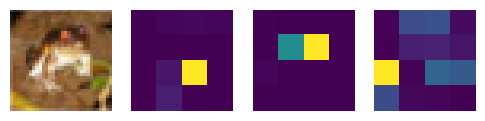

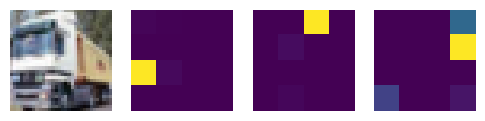

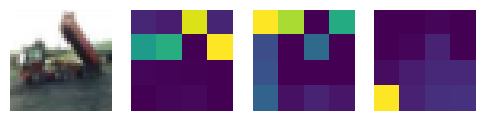

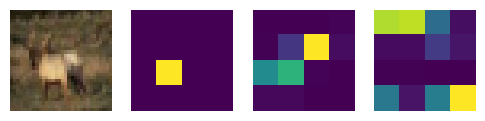

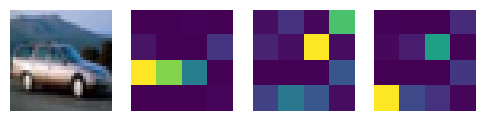

In [ ]:
# visualize the attention
def vis_attention(img, model):
    w_featmap = img.shape[-2] // 8 # patch size is 8
    h_featmap = img.shape[-1] // 8

    attentions = model.get_last_selfattention(img).detach()

    nh = attentions.shape[1] # number of head

    # we keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=8, mode="nearest")[0].cpu().numpy()

    # save attentions heatmaps
    fig, axs = plt.subplots(1, 1 + nh, figsize=(nh * 2, 2))

    for i, ax in enumerate(axs):
      if i == 0:
        ax.imshow(img[0].permute(1, 2, 0).cpu().numpy())
      else:
        ax.imshow(attentions[i-1])
      ax.axis('off')

print('On training images:')
for img in train_images:
  vis_attention(img[None], model)